In [100]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from datetime import datetime



In [89]:

#   --------------------------- parameters and data --------------
PATH = '../resources/inventory/'
supplier_list = [200067]  #200067 -julia
# Needs to open files and save them again as xlsx inside the excel

# important needs to delete first column of date which is empty
df = pd.read_excel(PATH + 'customer_transactions.xlsx', parse_dates=['Date'])  # inventory/transactions/reports/detailed/customer shipments

purchase_data_df = pd.read_excel(PATH + 'purchase_parameters.xlsx')#  invetory/part catalog/part parameter/purchae MRP parameters for parts
purchase_data_df = purchase_data_df[purchase_data_df['Preferred Vendor'].isin(supplier_list)]
availability_df = pd.read_excel(PATH + 'availability.xlsx')  # inventory/part catalog/parts report/ parts availability detailed
#start_date = '07/12/21'  # all information retrieved from the ERP# software will be discarded. format 'dd\mm\yy'
#start_date = start_date.split('/')[0] + '/' + start_date.split('/')[1] + '/' + start_date.split('/')[2]  # changing order


error with   part:  21AM180-05512L
index 0 is out of bounds for axis 0 with size 0


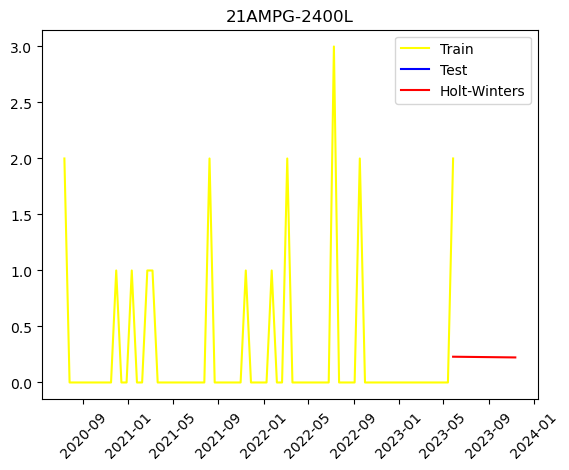

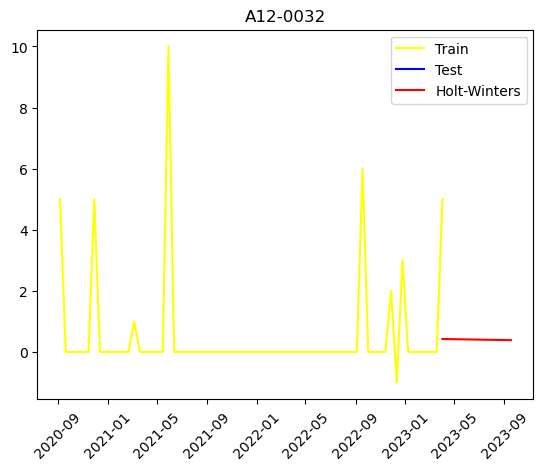

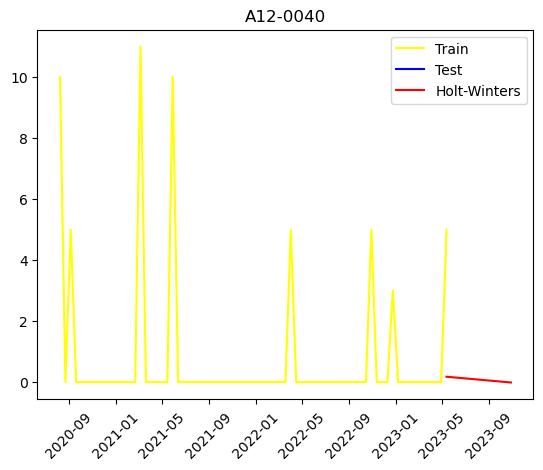

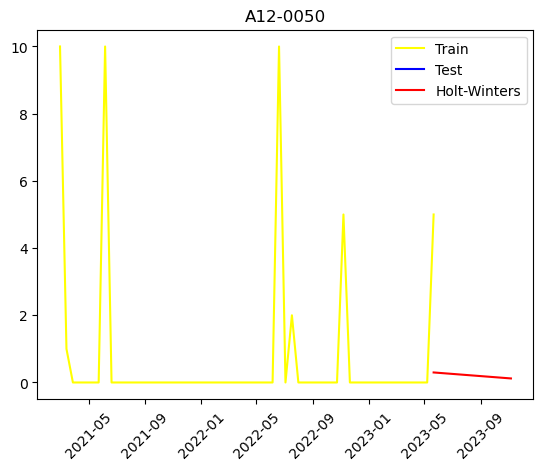

error with   part:  A12-0060
index 1 is out of bounds for axis 0 with size 1


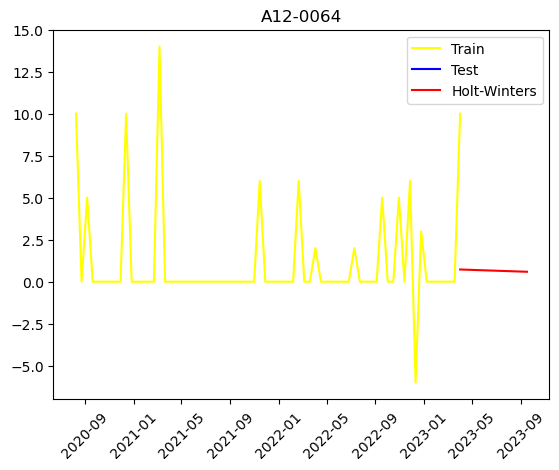

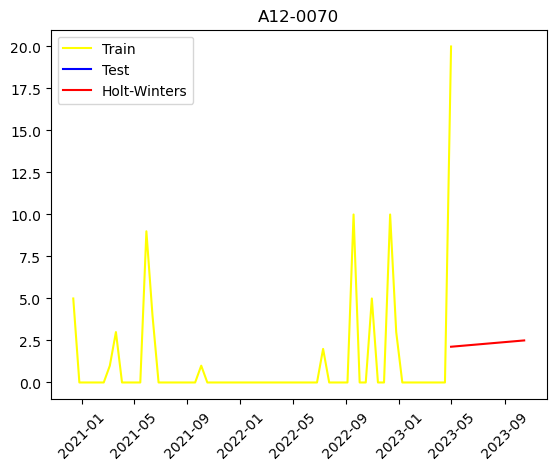

error with   part:  A12-0075
index 0 is out of bounds for axis 0 with size 0


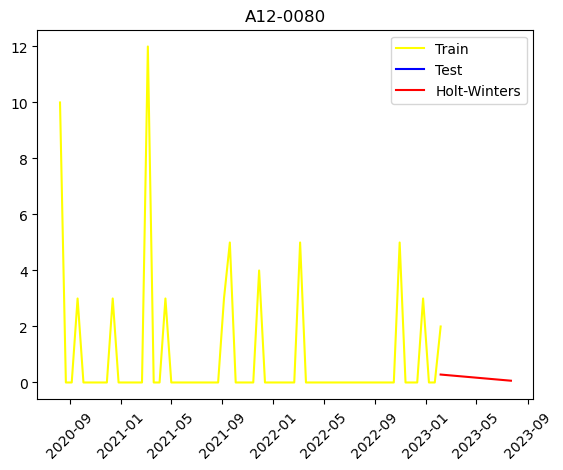

error with   part:  A12-0090
index 1 is out of bounds for axis 0 with size 1


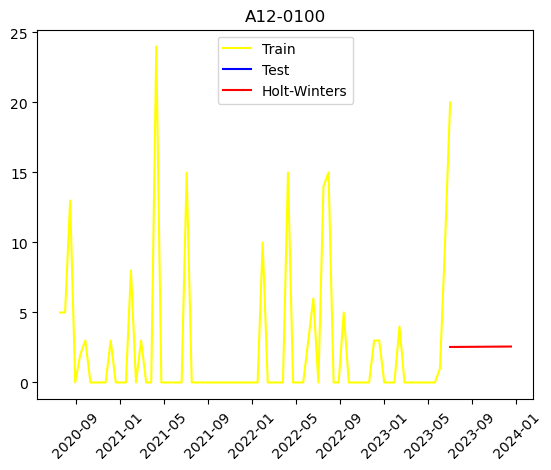

error with   part:  A12-0111
index 1 is out of bounds for axis 0 with size 1


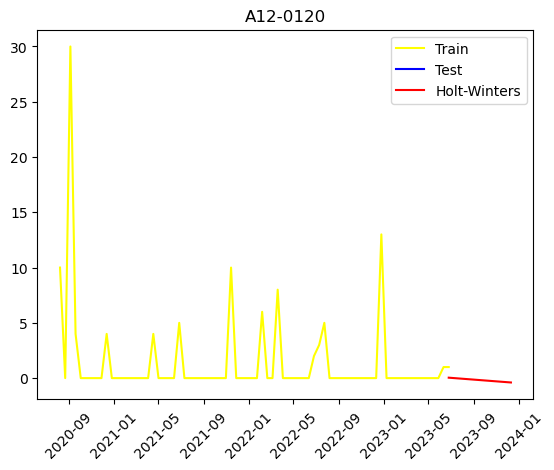

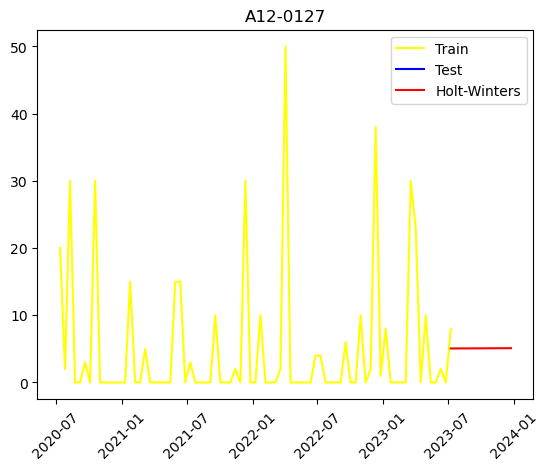

error with   part:  A12-0135
index 0 is out of bounds for axis 0 with size 0
error with   part:  A12-0140
index 0 is out of bounds for axis 0 with size 0


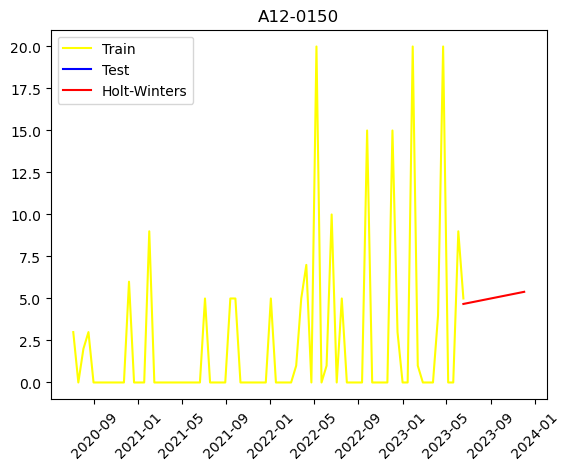

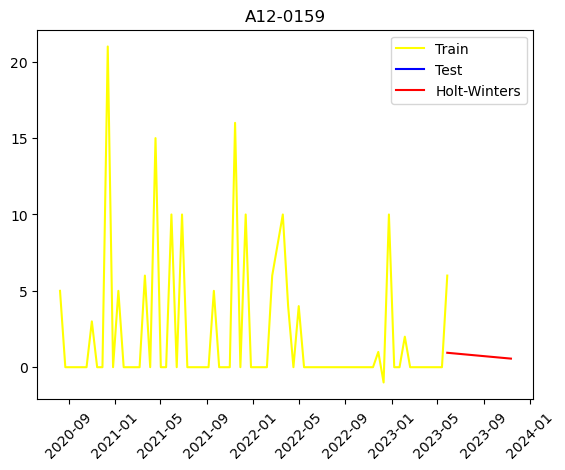

error with   part:  A12-0170
index 1 is out of bounds for axis 0 with size 1
error with   part:  A12-0180
index 1 is out of bounds for axis 0 with size 1


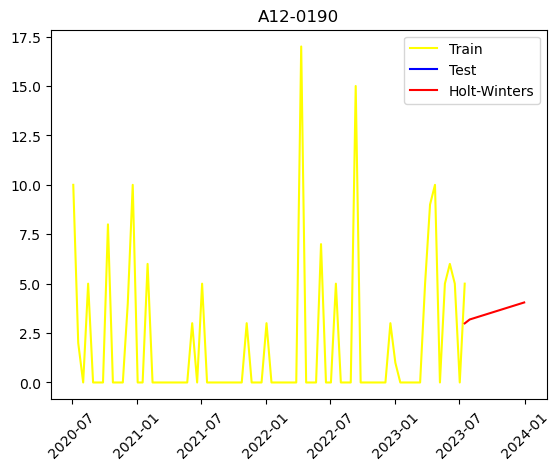

error with   part:  A12-0200
index 1 is out of bounds for axis 0 with size 1
error with   part:  A12-0210
index 0 is out of bounds for axis 0 with size 0
error with   part:  A12-0220
index 1 is out of bounds for axis 0 with size 1
error with   part:  A12-0230
index 0 is out of bounds for axis 0 with size 0
error with   part:  A12-0240
index 1 is out of bounds for axis 0 with size 1


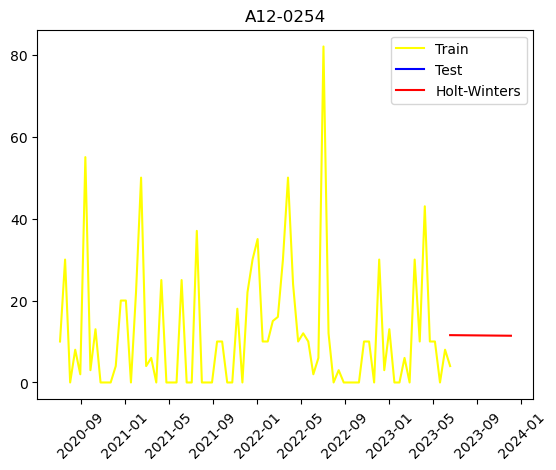

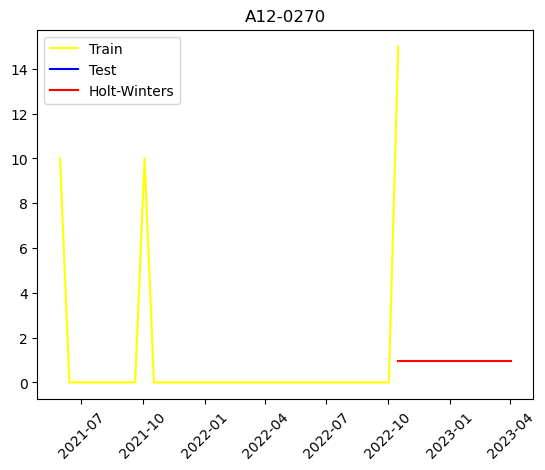

error with   part:  A12-0290
index 1 is out of bounds for axis 0 with size 1
error with   part:  A12-0300
index 1 is out of bounds for axis 0 with size 1
error with   part:  A12-0310
index 1 is out of bounds for axis 0 with size 1


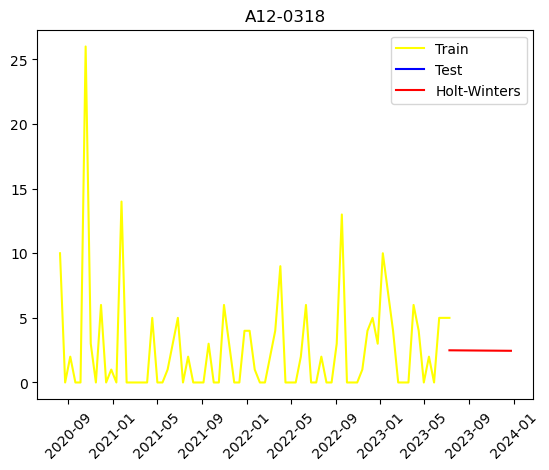

error with   part:  A12-0330
index 0 is out of bounds for axis 0 with size 0
error with   part:  A12-0340
index 0 is out of bounds for axis 0 with size 0


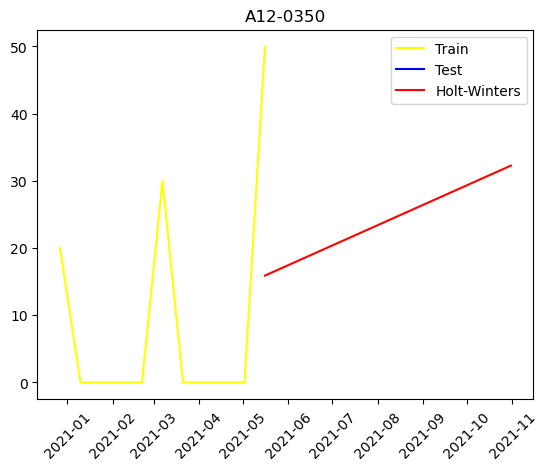

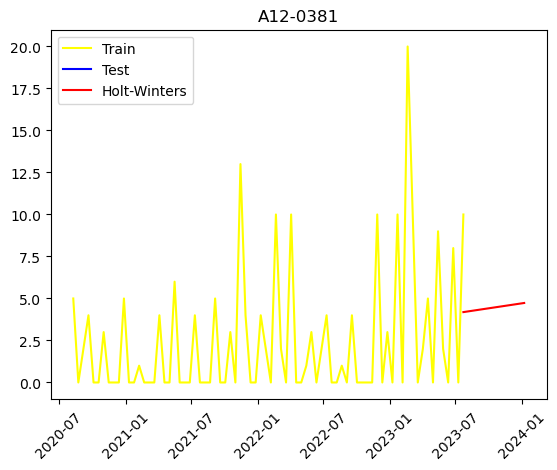

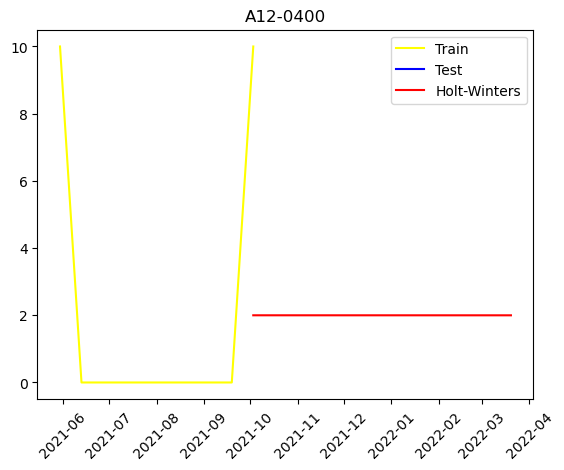

error with   part:  A12-0450
index 0 is out of bounds for axis 0 with size 0


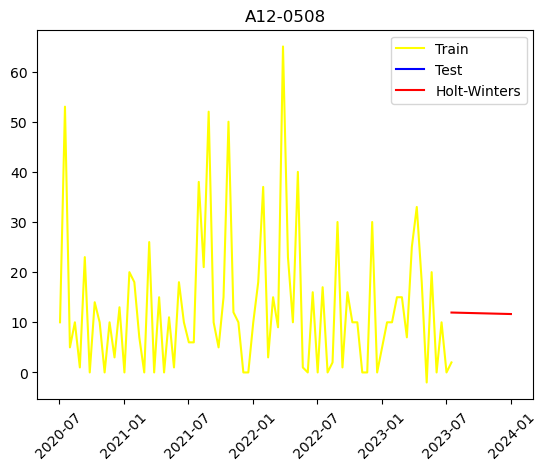

error with   part:  A12-0572
index 0 is out of bounds for axis 0 with size 0


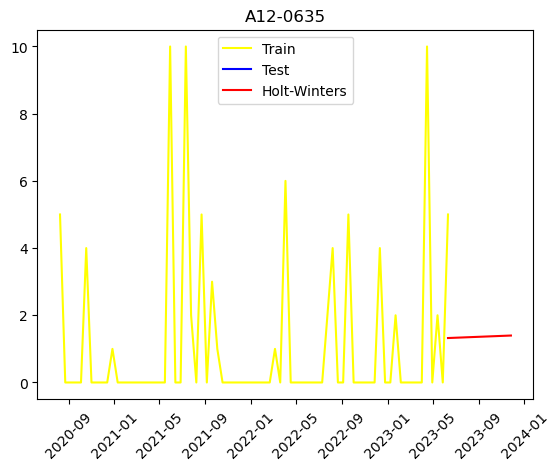

error with   part:  A12-0670
index 1 is out of bounds for axis 0 with size 1


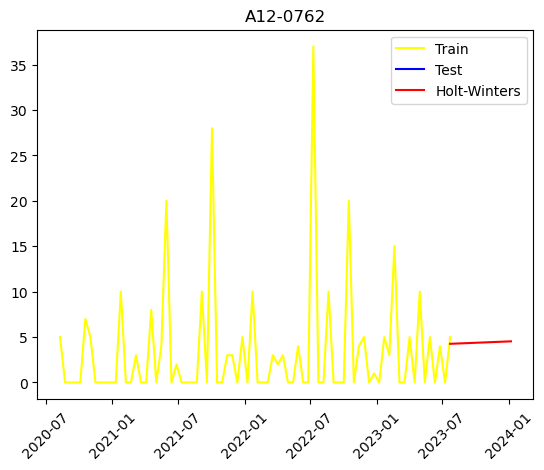

error with   part:  A12-0900
index 0 is out of bounds for axis 0 with size 0


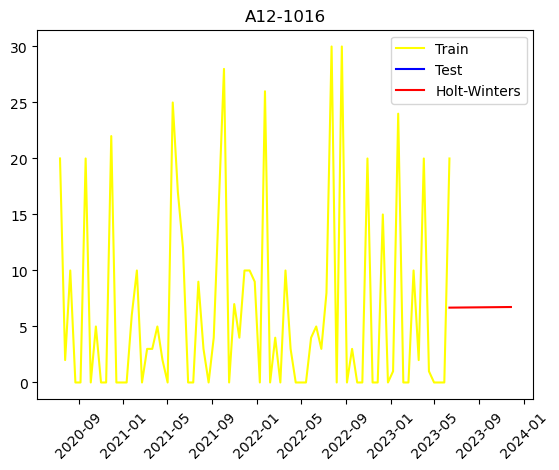

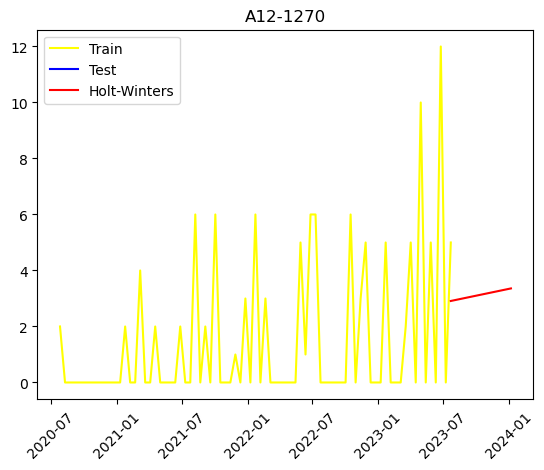

error with   part:  A12-1524
index 0 is out of bounds for axis 0 with size 0


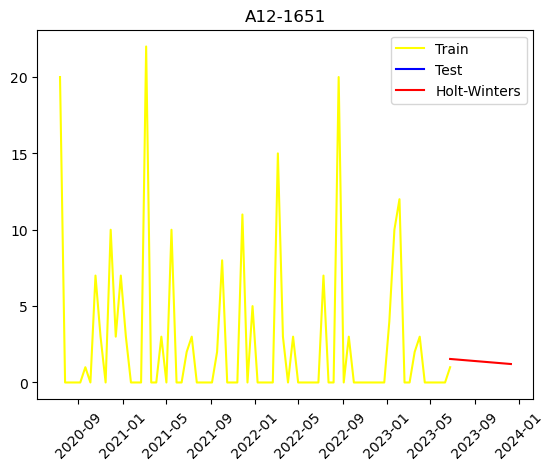

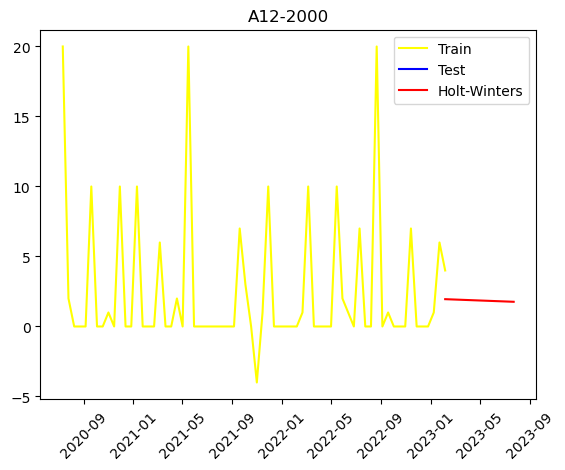

error with   part:  A12-2032
index 0 is out of bounds for axis 0 with size 0


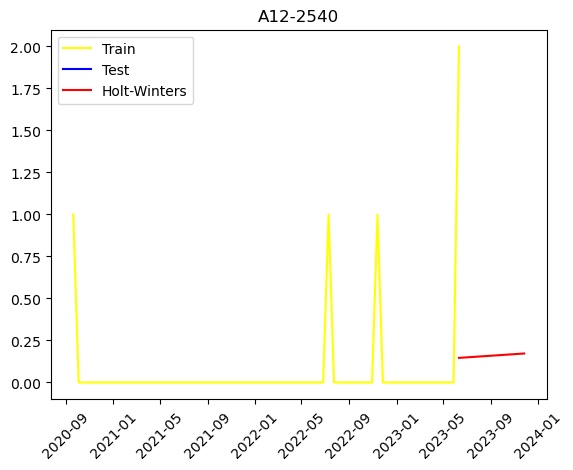

error with   part:  A12-2790
index 0 is out of bounds for axis 0 with size 0


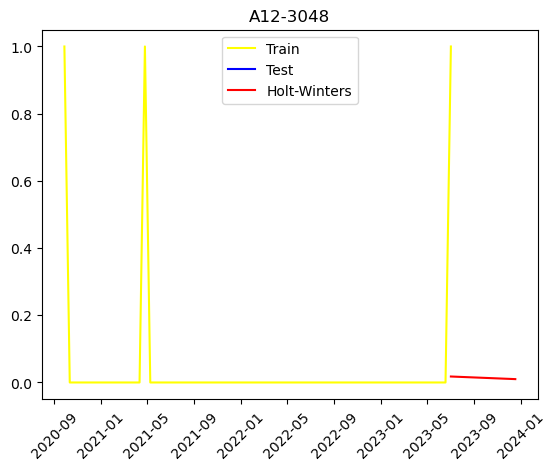

error with   part:  A12-3100
index 0 is out of bounds for axis 0 with size 0
error with   part:  A12-3556
index 0 is out of bounds for axis 0 with size 0
error with   part:  A12-3810
index 0 is out of bounds for axis 0 with size 0
error with   part:  A12-3900
index 0 is out of bounds for axis 0 with size 0
error with   part:  A12-4064
index 0 is out of bounds for axis 0 with size 0
error with   part:  A12-4572
index 0 is out of bounds for axis 0 with size 0
error with   part:  A12-5080
index 0 is out of bounds for axis 0 with size 0
error with   part:  A12-6096
index 0 is out of bounds for axis 0 with size 0
error with   part:  AS12-0260X0260
index 0 is out of bounds for axis 0 with size 0
error with   part:  AS12-0300X0150
index 0 is out of bounds for axis 0 with size 0


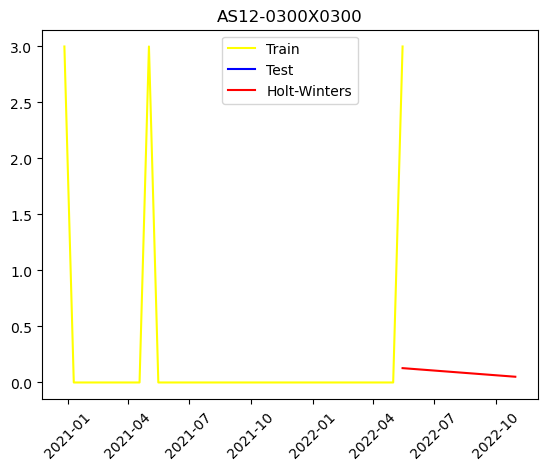

error with   part:  AS12-0330X0330
index 1 is out of bounds for axis 0 with size 1


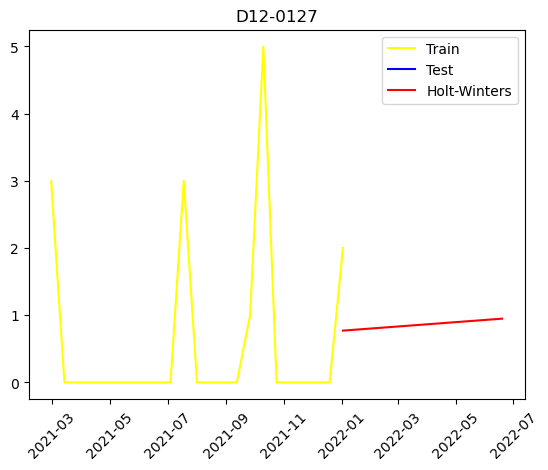

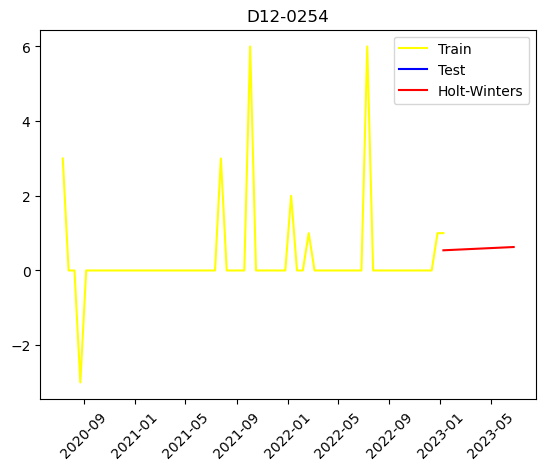

error with   part:  D12-0300
index 0 is out of bounds for axis 0 with size 0


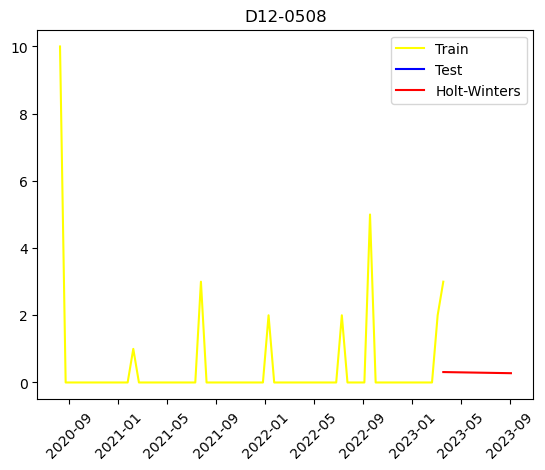

error with   part:  K12-0064
index 1 is out of bounds for axis 0 with size 1
error with   part:  K12-0127
index 1 is out of bounds for axis 0 with size 1


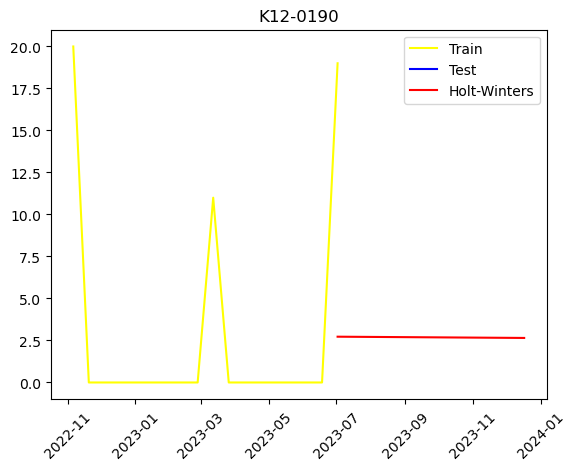

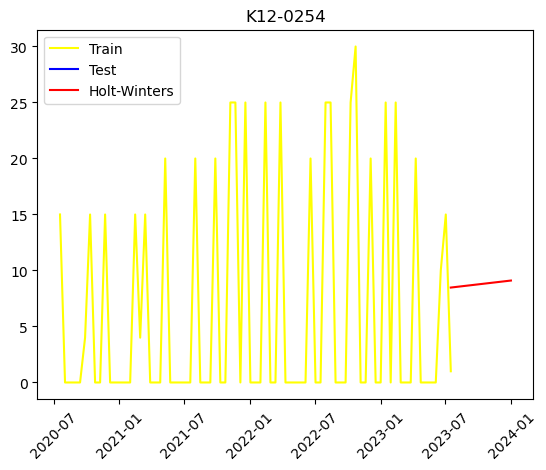

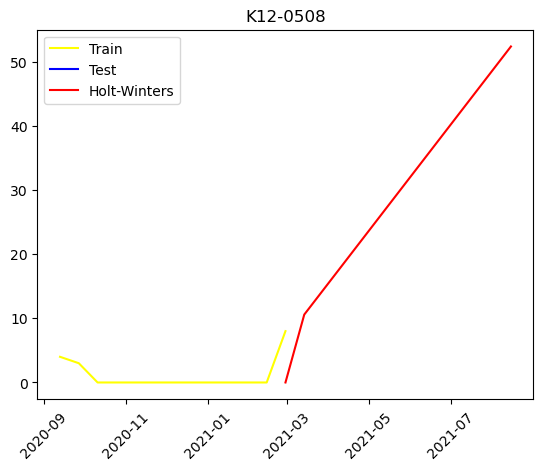

error with   part:  KD12-0032
index 0 is out of bounds for axis 0 with size 0
error with   part:  KD12-0071
index 0 is out of bounds for axis 0 with size 0
error with   part:  S295L-02360
index 0 is out of bounds for axis 0 with size 0
error with   part:  S295L-03150
index 0 is out of bounds for axis 0 with size 0
error with   part:  S295L-05512
index 1 is out of bounds for axis 0 with size 1
error with   part:  S295L-08000
index 0 is out of bounds for axis 0 with size 0
error with   part:  S295L-08661
index 1 is out of bounds for axis 0 with size 1
error with   part:  S295L-09450
index 1 is out of bounds for axis 0 with size 1


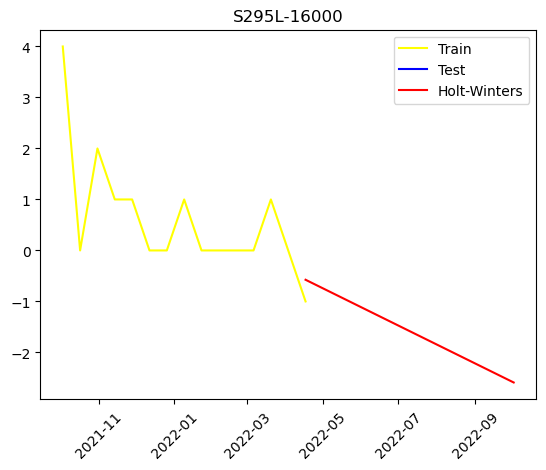

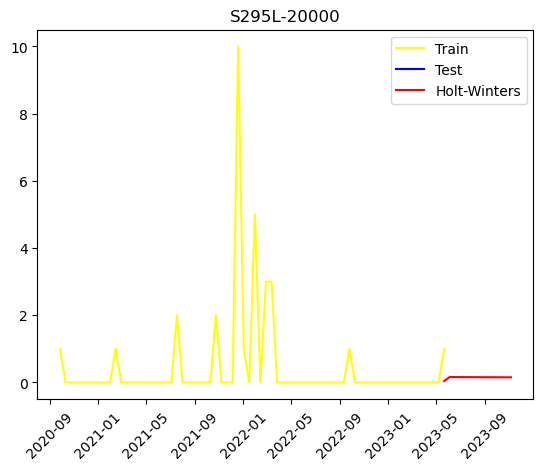

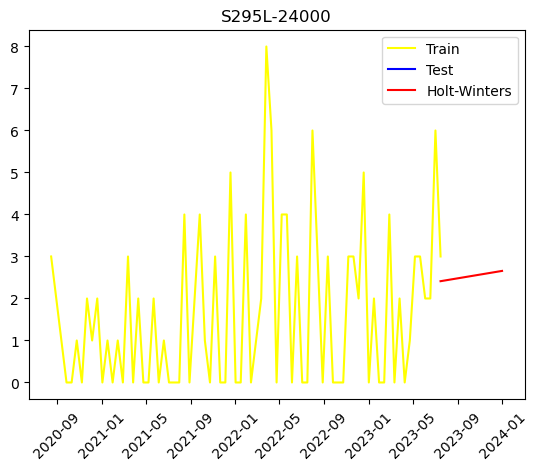

In [108]:
pn_list = list(purchase_data_df['Part Number'].unique())
order_part_list = []
forcast_steps = 12
avail_list = []
security_stock_list = []
recommended_order_list = []
sampling_period = '2W'
start_date = '2020-07-01'
forecast_list = []
train_test_ratio = 1
#pn_list = ['A12-1016', 'A12-1270']
for part in pn_list:
    history_df = df[df['Part Number'] == part][['Date', 'Quantity']]
    history_df = history_df[history_df['Date'] > start_date]

    history_df = history_df.set_index('Date')
    history_df = history_df.resample(sampling_period).sum()

    data = history_df['Quantity']
    # Split data into training and test sets
    train, test = data[:int(len(data)*train_test_ratio)], data[int(len(data)*train_test_ratio):]

    # Fit the model
    try:
        model = ExponentialSmoothing(train, trend='add', seasonal=None,seasonal_periods=1)
        model_fit = model.fit()
        order_part_list.append(part)
        forecast_list.append(model_fit.forecast(forcast_steps).sum())
        avail_list.append(availability_df[availability_df['Part Number'] == part]['Quantity'].values[0])

        recommended_order_list.append(forecast_list[-1]-avail_list[-1])
        # Forecast
        pred = model_fit.predict(start=train.index[-1], end=train.index[-1] + pd.Timedelta(weeks=forcast_steps*2))
        train = train.resample('2W').sum()
        test = test.resample('2W').sum()
        pred = pred.resample('2W').sum()

        # Plot the results
        plt.plot(train.index, train, label='Train', color='yellow')
        plt.plot(test.index, test, label='Test', color='blue')
        plt.plot(pred.index, pred, label='Holt-Winters', color='red')
        plt.legend(loc='best')
        plt.xticks(rotation=45)
        plt.title(part)

        plt.show()
    except Exception as e:
        print('error with   part: ', part)
        print(e)



current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

order_df = pd.DataFrame({'Part Number': order_part_list, 'Forecast': forecast_list, 'Availability': avail_list, 'Recommended Order': recommended_order_list})
order_df.to_excel(PATH + 'order%s.xlsx'%current_time, index=False)
order_parameter ={'start_date' : start_date, 'sampling_period' : sampling_period, 'forcast_steps' : forcast_steps, 'train_test_ratio' : train_test_ratio, 'supplier_list' : supplier_list}
pd.DataFrame(order_parameter, index=[1]).to_excel(PATH + 'order_parameter%s.xlsx'%current_time, index=False)

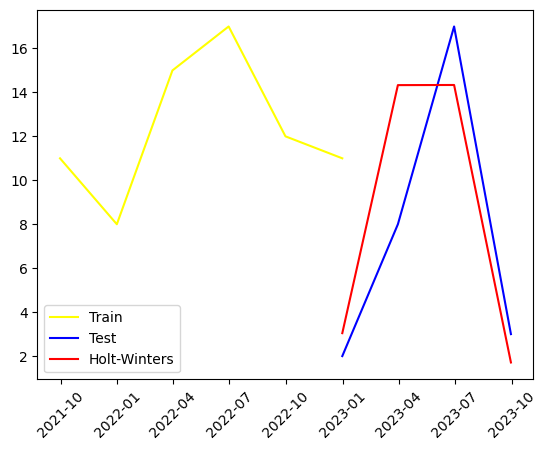

In [47]:
import pandas as pd

# Load your data
# We'll use a sample dataset for demonstration

data = history_df['Quantity']
# Split data into training and test sets
train, test = data[:int(len(data)*0.7)], data[int(len(data)*0.7):]

# Fit the model
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# Forecast
pred = model_fit.predict(start=test.index[0], end=test.index[-1])
train = train.resample('Q').sum()
test = test.resample('Q').sum()
pred = pred.resample('Q').sum()

# Plot the results
plt.plot(train.index, train, label='Train', color='yellow')
plt.plot(test.index, test, label='Test', color='blue')
plt.plot(pred.index, pred, label='Holt-Winters', color='red')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.show()
